In [12]:
import sys
from typing import List

import matplotlib
import requests
from pydantic import BaseModel


class OpenRankEntryItem(BaseModel):
    name: str


class OpenRankEntry(BaseModel):
    item: OpenRankEntryItem
    rank: int
    value: float
    rankDelta: int
    valueDelta: float


class OpenRank(BaseModel):
    type: str
    time: int
    data: List[OpenRankEntry]


year_range = range(2015, 2024)
region_list = ["chinese", "global"]

chinese_list: List[OpenRank] = []
global_list: List[OpenRank] = []

for year in year_range:
    for region in region_list:
        url = f"http://xlab-open-source.oss-cn-beijing.aliyuncs.com/open_leaderboard/open_rank/company/{region}/{year}.json"
        try:
            response = requests.get(
                url,
                headers={
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36 Edg/120.0.0.0"
                },
            )
            response.raise_for_status()

        except Exception as e:
            print(f"Error fetching data for year {year}: {e}")
            sys.exit()
        if response.status_code == 200:
            raw_dict = response.json()
            if region == "chinese":
                chinese_list.append(OpenRank.model_validate(raw_dict))
            else:
                global_list.append(OpenRank.model_validate(raw_dict))


In [13]:
# 展示数据是否正确
chinese_list[-1].data[0]
global_list[-1].data[0]

OpenRankEntry(item=OpenRankEntryItem(name='Microsoft'), rank=1, value=215043.71, rankDelta=0, valueDelta=8453.06)

In [14]:
# 提取美国企业的名字
import requests
import yaml

# URL 指向所需解析的 YAML 文件
url = "https://raw.githubusercontent.com/X-lab2017/open-digger/master/labeled_data/regions/US.yml"

# 发送请求并获取文件内容
response = requests.get(url)
data = response.content

# 解析 YAML 内容
companies_data = yaml.safe_load(data)
company_labels = companies_data['data']['labels']
usa_companies = [label.split('/')[-1] for label in company_labels]
usa_companies

['adobe',
 'amazon',
 'databricks',
 'google',
 'ibm',
 'meta',
 'microsoft',
 'mozilla',
 'oracle',
 'paypal',
 'redhat',
 'salesforce',
 'vmware',
 'netflix',
 'hashicorp',
 'deepmind',
 'openai',
 'nvidia',
 'uber',
 'intel',
 'mycroftai',
 'h2oai',
 'twitter',
 'deno',
 'netlify',
 'anaconda',
 'acquia',
 'alfresco',
 'alluxio',
 'cloudbees',
 'cloudera',
 'confluent',
 'couchbase',
 'docker',
 'elastic',
 'enterprisedb',
 'fastly',
 'forgerock',
 'instructure',
 'jfrog',
 'kaltura',
 'liferay',
 'magento',
 'mapbox',
 'mongodb',
 'mulesoft',
 'neo4j',
 'nicira',
 'openresty',
 'pentaho',
 'pivotal',
 'postman',
 'puppet_labs',
 'rapid7',
 'redis',
 'segment',
 'sourcefire',
 'talend',
 'terminus',
 'treasure_data',
 'varnish',
 'wordpress']

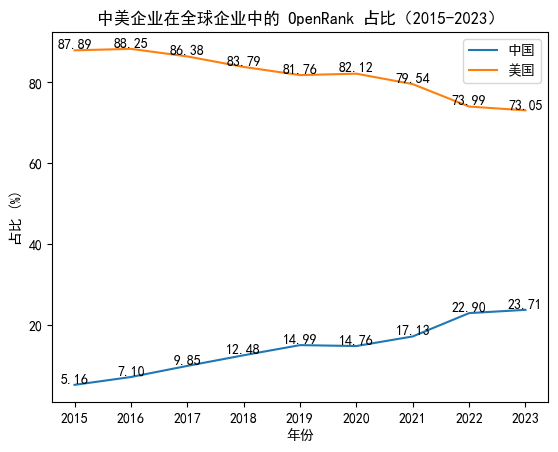

In [17]:
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['font.size'] = 10
# 数据准备
years = list(year_range)
idx_list = list(range(len(chinese_list)))
china_company_percentage = [0] * len(idx_list)
usa_company_percentage = [0] * len(idx_list)

for idx in idx_list:
    chinese_total = sum(entry.value for entry in chinese_list[idx].data)
    usa_total = sum(entry.value for entry in global_list[idx].data if
                    entry.item.name.lower() in (name.lower() for name in usa_companies)) 
    global_total = sum(entry.value for entry in global_list[idx].data)
    china_company_percentage[idx] = chinese_total / global_total * 100
    usa_company_percentage[idx] = usa_total / global_total * 100

# 创建折线图
plt.plot(years, china_company_percentage, label='中国')
plt.plot(years, usa_company_percentage, label='美国')

# 在每个点上添加数值标签
for x, y_china, y_usa in zip(years, china_company_percentage, usa_company_percentage):
    plt.text(x, y_china, f'{y_china:.2f}', ha='center', va='bottom')
    plt.text(x, y_usa, f'{y_usa:.2f}', ha='center', va='bottom')

# 添加标题和标签
plt.title('中美企业在全球企业中的 OpenRank 占比（2015-2023）')
plt.xlabel('年份')
plt.ylabel('占比 (%)')

# 显示图例
plt.legend()

# 显示图表
plt.show()